# Project Overview: Time-series anomaly detection methods for unlabeled data

Goal:
To detect anomalies (detect occasional outliers) in network traffic

Methods:
- K-means: Control, should be flop
- DBSCAN: Better than flop k-means
- Isolation Forest Mixed results so far

Evaluation:
- Include a Correlation Matrix!
- Precision
- recall

Useful paper we steal dataset from:
- https://www.nature.com/articles/s41597-025-04603-x
- Dataset: CESNET-TimeSeries24
https://zenodo.org/records/13382427
- Details:
Use sample IP addresses cause other one is 40GB
Uses campus/institution data which would look different to datasets generated in different situations maybe?
  - unlabeled

Dataset 2: N-BaIoT
It’s a labeled Dataset with Botnet and normal traffic for IoT devices. Its files are broken up into different types of botnet attacks.
https://www.kaggle.com/datasets/mkashifn/nbaiot-dataset?select=1.gafgyt.combo.csv

- There’s a bunch of options but let’s just go with
Danmini_Doorbell (1), benign traffic, and gafgyt attack

Other Relevant research papers:
- https://www.mdpi.com/1424-8220/23/5/2844
- Anomaly Detection using Clustering:
https://www.jcbi.org/index.php/Main/article/view/598


In [30]:
import pandas as pd
import glob

path = "/Users/diandian/Desktop/course-project-cdi1diandian0309/data/CESNET_agg_10_minutes"

#files = glob.glob("/data/CESNET_agg_10_minutes/*.csv")
files = glob.glob(f"{path}/*.csv")
df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

In [2]:
print(df.columns)
df

Index(['id_time', 'n_flows', 'n_packets', 'n_bytes', 'n_dest_asn',
       'n_dest_ports', 'n_dest_ip', 'tcp_udp_ratio_packets',
       'tcp_udp_ratio_bytes', 'dir_ratio_packets', 'dir_ratio_bytes',
       'avg_duration', 'avg_ttl'],
      dtype='object')


,id_time,n_flows,n_packets,n_bytes,n_dest_asn,n_dest_ports,n_dest_ip,tcp_udp_ratio_packets,tcp_udp_ratio_bytes,dir_ratio_packets,dir_ratio_bytes,avg_duration,avg_ttl
0,56,8,105,38628,5.0,3.0,7.0,1.00,1.00,0.59,0.35,0.33,135.62
1,57,26,911,647102,6.0,2.0,23.0,0.66,0.44,0.37,0.15,28.24,116.73
2,58,6,167,28759,4.0,2.0,6.0,1.00,1.00,0.38,0.15,90.31,108.00
3,59,12,96,22605,6.0,5.0,9.0,1.00,1.00,0.42,0.29,34.51,107.50
4,60,5,40,13655,4.0,4.0,5.0,1.00,1.00,0.90,0.99,53.65,157.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6867533,40289,4,5,308,3.0,4.0,4.0,0.60,0.45,0.20,0.27,0.00,198.75
6867534,40291,3,3,116,3.0,3.0,3.0,0.67,0.72,0.33,0.28,0.00,186.33
6867535,40295,9,10,388,5.0,5.0,7.0,0.50,0.54,0.40,0.37,0.01,140.33
6867536,40296,9,10,424,4.0,4.0,9.0,0.30,0.41,0.50,0.42,6.07,118.00


1. PRE PROCESSING FOR CSNET DATASET

In [31]:
#BASIC INFORMATION
print("\ndataset info:")
print(df.info())

#filling in any missing columns
missing_cols = df.columns[df.isnull().any()].tolist()

if missing_cols:
    for col in missing_cols:
        missing_pct = df[col].isnull().mean() * 100

        if df[col].dtype in ['float64', 'int64']: #numerical -> using median
            df[col] = df[col].fillna(df[col].median())
        else: #catergorical -> using mode
            mode_vals = df[col].mode()

            if not mode_vals.empty:
                mode_val = mode_vals[0]
                df[col] = df[col].fillna(mode_val)
            else:
                df[col] = df[col].fillna("Unknown")
else:
    print("none yippee!")

#check duplicates
duplicates = df.duplicated().sum()

if duplicates > 0:
    df = df.drop_duplicates()
    print("duplicates removed :D")

display(df.head())


dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6867538 entries, 0 to 6867537
Data columns (total 13 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id_time                int64  
 1   n_flows                int64  
 2   n_packets              int64  
 3   n_bytes                int64  
 4   n_dest_asn             float64
 5   n_dest_ports           float64
 6   n_dest_ip              float64
 7   tcp_udp_ratio_packets  float64
 8   tcp_udp_ratio_bytes    float64
 9   dir_ratio_packets      float64
 10  dir_ratio_bytes        float64
 11  avg_duration           float64
 12  avg_ttl                float64
dtypes: float64(9), int64(4)
memory usage: 681.1 MB
None
none yippee!
duplicates removed :D


,id_time,n_flows,n_packets,n_bytes,n_dest_asn,n_dest_ports,n_dest_ip,tcp_udp_ratio_packets,tcp_udp_ratio_bytes,dir_ratio_packets,dir_ratio_bytes,avg_duration,avg_ttl
0,56,8,105,38628,5.0,3.0,7.0,1.00,1.00,0.59,0.35,0.33,135.62
1,57,26,911,647102,6.0,2.0,23.0,0.66,0.44,0.37,0.15,28.24,116.73
2,58,6,167,28759,4.0,2.0,6.0,1.00,1.00,0.38,0.15,90.31,108.00
3,59,12,96,22605,6.0,5.0,9.0,1.00,1.00,0.42,0.29,34.51,107.50
4,60,5,40,13655,4.0,4.0,5.0,1.00,1.00,0.90,0.99,53.65,157.60


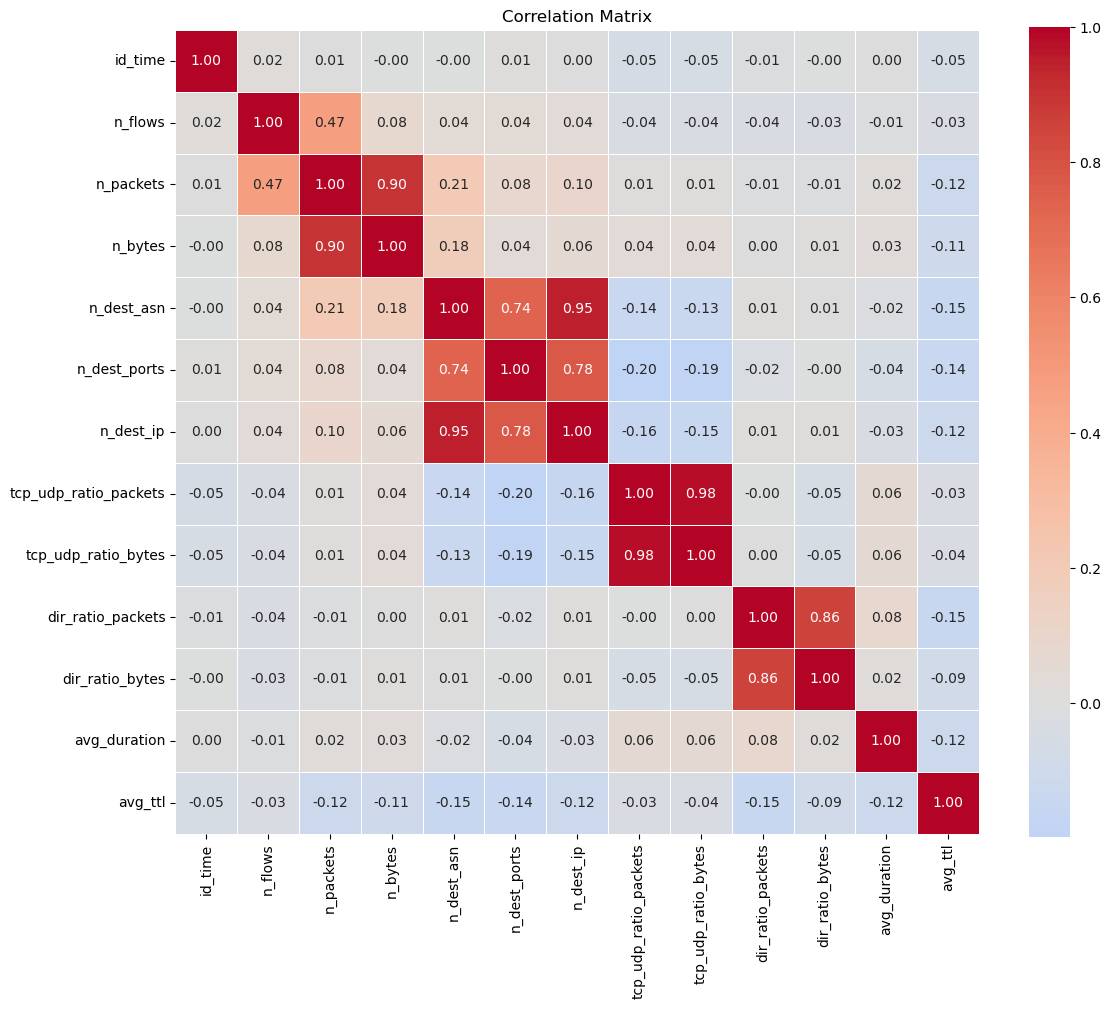


 highly correlated feature pairs:

Feature 1: n_packets, Feature 2: n_bytes, corr = 0.898084
Feature 1: n_dest_asn, Feature 2: n_dest_ip, corr = 0.951843
Feature 1: tcp_udp_ratio_packets, Feature 2: tcp_udp_ratio_bytes, corr = 0.977072
Feature 1: dir_ratio_packets, Feature 2: dir_ratio_bytes, corr = 0.859511


In [ ]:
#correlation matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,square=True, linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

print("\n highly correlated feature pairs:\n")
high_corr_pairs = []

corr_matrix_cols_len =len(correlation_matrix.columns)
for i in range(corr_matrix_cols_len):
    for j in range(i + 1, corr_matrix_cols_len):
        val = correlation_matrix.iloc[i, j]

        if abs(val) > 0.8:
            feature_1 = correlation_matrix.columns[i]
            feature_2 = correlation_matrix.columns[j]

            high_corr_pairs.append((feature_1, feature_2, val))
            print(f"Feature 1: {feature_1}, Feature 2: {feature_2}, corr = {val:4f}")

if not high_corr_pairs:
    print("no highly correlated features found :(")

In [32]:
#feature selection
#time series -> diverse -> highly correlated?

if high_corr_pairs:
    features_to_consider_removing = set()

    for feat1, feat2, corr in high_corr_pairs:
        if 'ratio' in feat2.lower():
            features_to_consider_removing.add(feat2)
        else:
            features_to_consider_removing.add(feat1)

    features_to_keep = []

    for col in numerical_cols:
        if col not in features_to_consider_removing:
            features_to_keep.append(col)

    print(f"removed {len(features_to_consider_removing)} features")
else:
    features_to_keep = numerical_cols.copy()
    print("keeping numerical features")

print(f"\nselected features ({len(features_to_keep)} features):")
for i, feature in enumerate(features_to_keep):
    print(f"{i+1}.) {feature}")

removed 4 features

selected features (9 features):
1.) id_time
2.) n_flows
3.) n_bytes
4.) n_dest_ports
5.) n_dest_ip
6.) tcp_udp_ratio_packets
7.) dir_ratio_packets
8.) avg_duration
9.) avg_ttl


In [36]:
#feature scaling
#from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

#scaler = RobustScaler()
scaler = StandardScaler()

x = df[features_to_keep].copy()
x_scaled = scaler.fit_transform(x)
x_scaled_df = pd.DataFrame(x_scaled, columns=features_to_keep)

print(x_scaled_df.head())

print("\nafter StandardScaler:")
print(f"mean: {x_scaled_df.mean(axis=0).values[:3]}")
print(f"std: {x_scaled_df.std(axis=0).values[:3]}")

    id_time   n_flows   n_bytes  n_dest_ports  n_dest_ip  \
0 -1.669433 -0.022876 -0.103838     -0.106229  -0.096282   
1 -1.669346 -0.022557 -0.098662     -0.106764  -0.086222   
2 -1.669259 -0.022912 -0.103922     -0.106764  -0.096911   
3 -1.669172 -0.022805 -0.103975     -0.105160  -0.095025   
4 -1.669085 -0.022929 -0.104051     -0.105695  -0.097540   

   tcp_udp_ratio_packets  dir_ratio_packets  avg_duration   avg_ttl  
0               0.748341           0.534135     -0.503171  0.002145  
1              -0.184780          -0.463745      0.180616 -0.352031  
2               0.748341          -0.418387      1.701315 -0.515713  
3               0.748341          -0.236954      0.334230 -0.525088  
4               0.748341           1.940238      0.803155  0.414257  

after StandardScaler:
mean: [-1.51045077e-16  3.87401421e-18  6.07233063e-18]
std: [1.00000007 1.00000007 1.00000007]


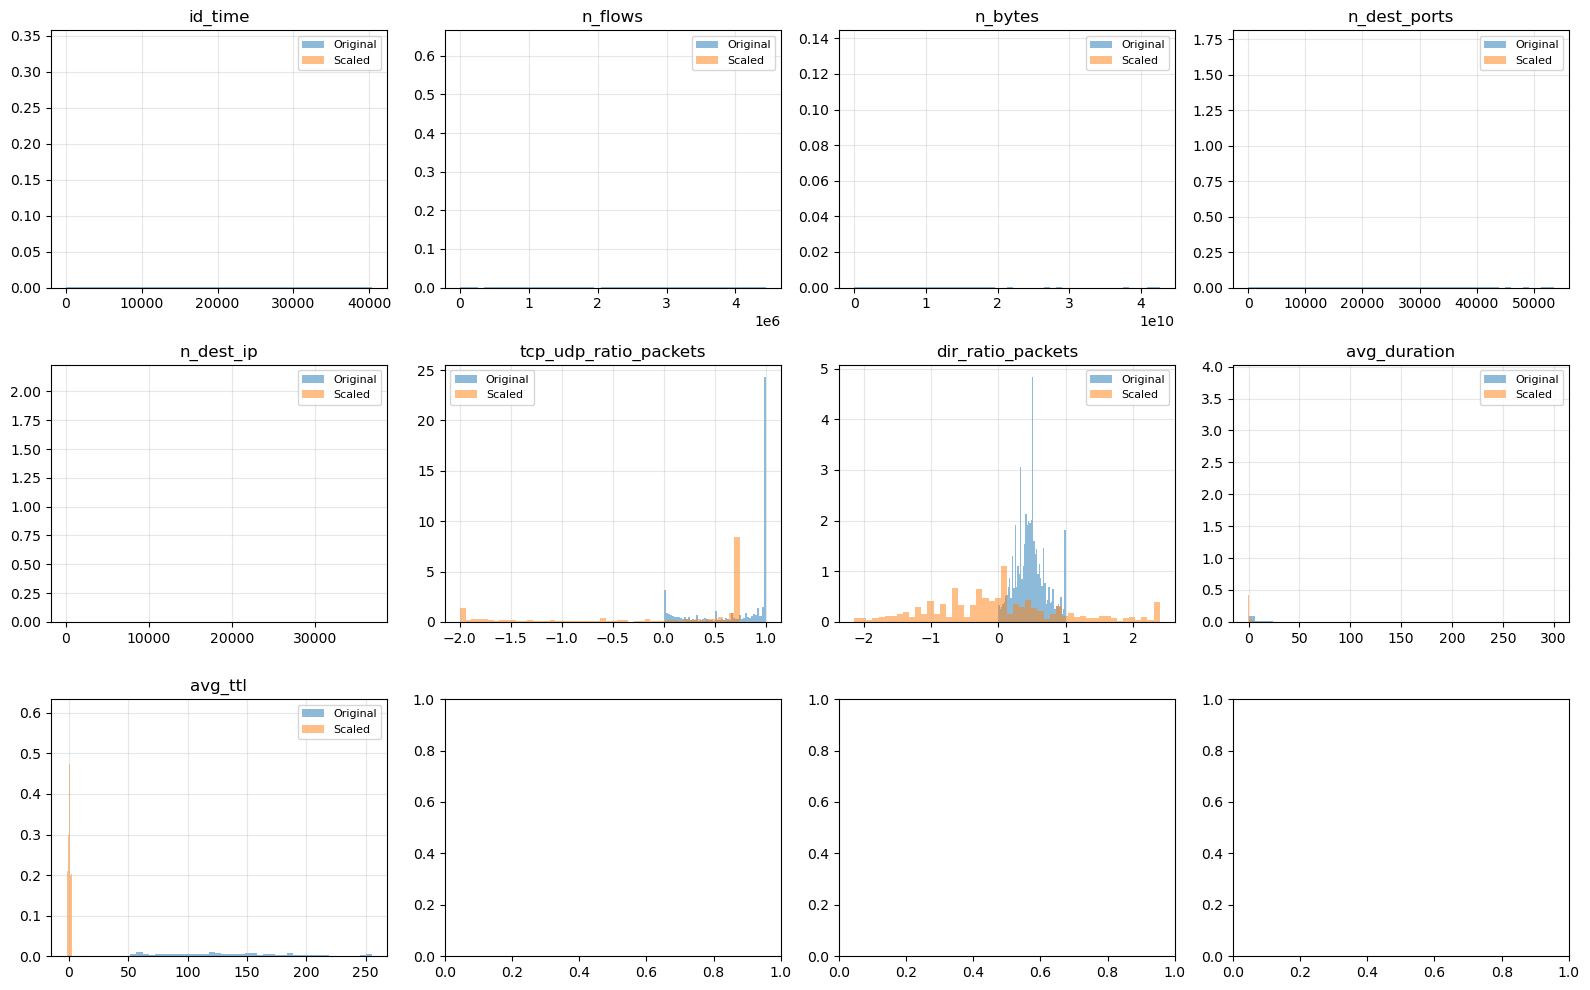

In [37]:
#visualizations

#distributions
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.ravel()

for idx, col in enumerate(features_to_keep):
    axes[idx].hist(x[col].values, bins=50, alpha=0.5, label='Original', density=True)
    axes[idx].hist(x_scaled_df[col].values, bins=50, alpha=0.5, label='Scaled', density=True)
    axes[idx].set_title(f'{col}')
    axes[idx].legend(fontsize=8)
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

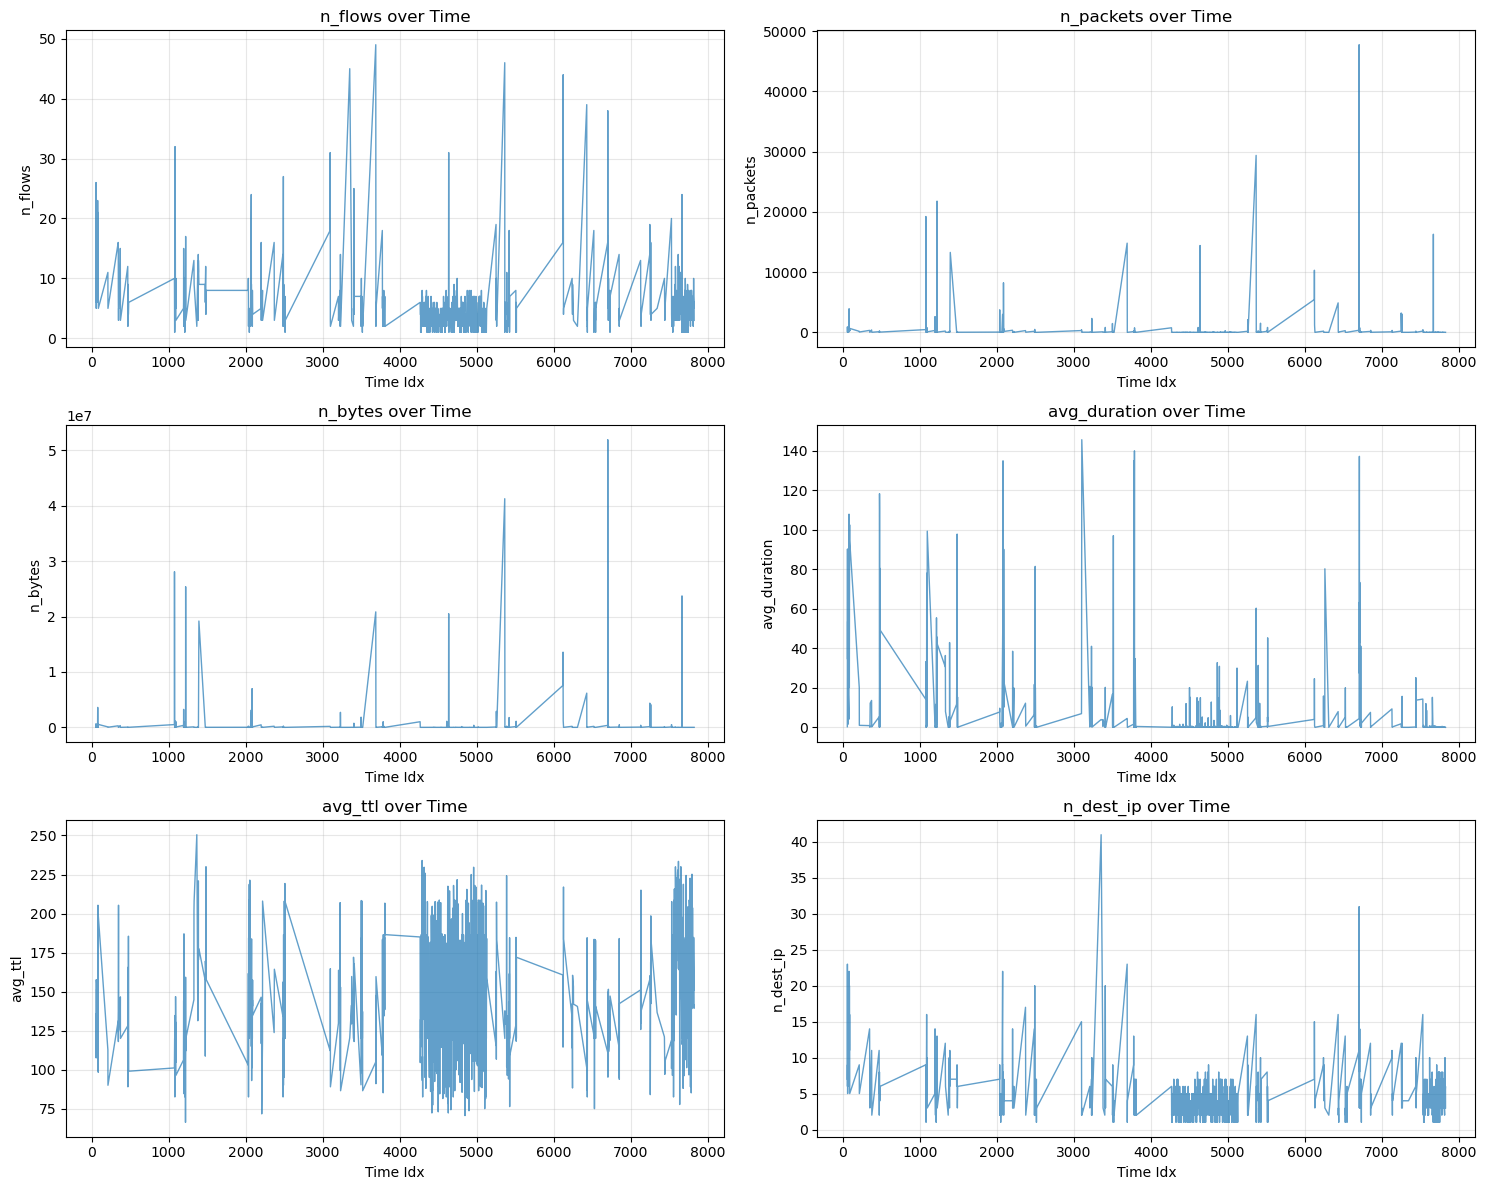

In [38]:
#time distribution visuals
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
key_metrics = ['n_flows', 'n_packets', 'n_bytes', 'avg_duration', 'avg_ttl', 'n_dest_ip']

for idx, metric in enumerate(key_metrics):
    ax = axes[idx // 2, idx % 2]

    time_pts = df['id_time'].values[:1000]
    metric_vals = df[metric].values[:1000]

    ax.plot(time_pts, metric_vals, alpha=0.7, linewidth=1)
    ax.set_title(f'{metric} over Time')
    ax.set_xlabel('Time Idx')
    ax.set_ylabel(metric)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [39]:
#saving data
preprocessed = {
    'X_original': x,
    'X_scaled': x_scaled_df,
    'features': features_to_keep,
    'scaler': scaler
}

x_scaled_df.to_csv('cesnet_preprocessed_scaled.csv', index=False)
x.to_csv('cesnet_preprocessed_original.csv', index=False)

2. Kmeans

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

X = x_scaled_df.values
print(X.shape)

x_train, x_test = train_test_split(X, test_size=0.3, random_state=42)
print(f"training test shape: {x_train.shape}")
print(f"testing set shape: {x_test.shape}")

silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels_train = kmeans.fit_predict(x_train)
    silhouette_avg = silhouette_score(x_train, cluster_labels_train)
    silhouette_scores.append(silhouette_avg)
    print(f"k={k}: silhouette Score = {silhouette_avg:.4f}")

optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\noptimal k: {optimal_k}")
print(f"\n best silhouette score: {max(silhouette_scores):.4f}")

plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o', color='blue', linestyle='--', linewidth=2)
plt.axvline(x=optimal_k, color='red', linestyle=':', alpha=0.7, label=f'Optimal k={optimal_k}')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title(f'Silhouette Scores for K-means (Training Data)\nOptimal k = {optimal_k}')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

(6852292, 9)
training test shape: (4796604, 9)
testing set shape: (2055688, 9)


KeyboardInterrupt: 

In [42]:
#nbfhewnfbghrewknfhewkenrh
from sklearn.model_selection import train_test_split

X_scaled = x_scaled_df.values

print(f"total dataset size: {X_scaled.shape}")
print(f"scaled data - Mean: {X_scaled.mean(axis=0)[:3]}")
print(f"scaled data - Std: {X_scaled.std(axis=0)[:3]}")

x_train, x_test = train_test_split(
    X_scaled,
    test_size=0.3,
    random_state=42,
    shuffle=True
)

print(f"\ntraining set shape: {x_train.shape}")
print(f"test set shape: {x_test.shape}")

print(f"\nx_train - Mean: {x_train.mean(axis=0)[:3]}")
print(f"x_train - Std: {x_train.std(axis=0)[:3]}")

print(f"\nx_test - Mean: {x_test.mean(axis=0)[:3]}")
print(f"x_test - Std: {x_test.std(axis=0)[:3]}")

total dataset size: (6852292, 9)
scaled data - Mean: [-1.51045077e-16  3.87401421e-18  6.07233063e-18]
scaled data - Std: [1. 1. 1.]

training set shape: (4796604, 9)
test set shape: (2055688, 9)

x_train - Mean: [-2.00580692e-06 -9.17349773e-05 -1.43968467e-04]
x_train - Std: [1.00005422 0.99724917 1.00182052]

x_test - Mean: [4.68021486e-06 2.14048221e-04 3.35926331e-04]
x_test - Std: [0.99987348 1.00638933 0.99573909]


In [43]:
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import time

print(f"dataset size: {x_train.shape}")

SAMPLE_SIZE = 50000

np.random.seed(42)
sample_indices = np.random.choice(len(x_train), SAMPLE_SIZE, replace=False)
x_train_sample = x_train[sample_indices]

print(f"Sample shape: {x_train_sample.shape}")

k_range = range(2, 8)
silhouette_scores = []

start_time = time.time()

for k in k_range:
    print(f"on this k: {k}")
    k_start = time.time()

    kmeans = MiniBatchKMeans(
        n_clusters=k,
        random_state=42,
        batch_size=1000,
        max_iter=50,
        n_init=3
    )

    cluster_labels = kmeans.fit_predict(x_train_sample)
    silhouette_avg = silhouette_score(x_train_sample, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    k_elapsed = time.time() - k_start
    print(f"k={k}: silhouette = {silhouette_avg:.4f} (total time: {k_elapsed:.1f}s)")

total_time = time.time() - start_time
print(f"\n total time: {total_time:.4f}s")
print(f"optimal k: {k_range[np.argmax(silhouette_scores)]}")

dataset size: (4796604, 9)
Sample shape: (50000, 9)
on this k: 2
k=2: silhouette = 0.1444 (total time: 49.3s)
on this k: 3
k=3: silhouette = 0.1354 (total time: 28.9s)
on this k: 4
k=4: silhouette = 0.1334 (total time: 31.7s)
on this k: 5
k=5: silhouette = 0.1531 (total time: 35.7s)
on this k: 6
k=6: silhouette = 0.1909 (total time: 35.2s)
on this k: 7
k=7: silhouette = 0.1812 (total time: 40.4s)

 total time: 221.4069s
optimal k: 6


In [44]:
#optimal k = 6

chosen_k = 6

final_kmeans = MiniBatchKMeans(
    n_clusters=chosen_k,
    random_state=42,
    batch_size=1000,
    max_iter=200,
    n_init=10,
    verbose=0
)

final_kmeans.fit(x_train_sample)
print("model trained yippee")

sample_labels = final_kmeans.labels_
sample_dists = final_kmeans.transform(x_train_sample)
sample_pt_dists = sample_dists[np.arange(len(sample_dists)), sample_labels]

print("cluster distribution:")
unique, counts = np.unique(sample_labels, return_counts=True)

for cluster, count in zip(unique, counts):
    percentage = (count / len(sample_labels)) * 100
    print(f"cluster {cluster}: {count:,} samples ({percentage:.2f}%)")

model trained yippee
cluster distribution:
cluster 0: 12,538 samples (25.08%)
cluster 1: 10,818 samples (21.64%)
cluster 2: 12,140 samples (24.28%)
cluster 3: 8,396 samples (16.79%)
cluster 4: 2,716 samples (5.43%)
cluster 5: 3,392 samples (6.78%)


In [45]:
mean_dist = np.mean(sample_pt_dists)
std_dist = np.std(sample_pt_dists)

#2 strategies -> choosing from centroid dist or clusters

#centroid strategy
print("centroid strategy")
print(f"mean distance to centroid: {mean_dist:.4f}")
print(f"std of distances: {std_dist:.4f}")

threshold_multiplier = 2.0
dist_threshold = mean_dist + threshold_multiplier * std_dist

sample_anomalies_dist = sample_pt_dists > dist_threshold
sample_anomaly_pct_dist = np.sum(sample_anomalies_dist) / len(x_train_sample) * 100

print(f"distance threshold: {dist_threshold:.4f}")
print(f"# of anomalies detected: {np.sum(sample_anomalies_dist):,}")
print(f"anomaly %: {sample_anomaly_pct_dist:.2f}%")

# smallest cluster strategy
print("cluster strategy")
if counts[0] < counts[1]:
    anomaly_cluster = 0
    normal_cluster = 1
else:
    anomaly_cluster = 1
    normal_cluster = 0

sample_anomalies_cluster = (sample_labels == anomaly_cluster)
sample_anomaly_pct_cluster = np.sum(sample_anomalies_cluster) / len(x_train_sample) * 100

print(f"normal cluster: Cluster {normal_cluster} ({counts[normal_cluster] / len(x_train_sample)*100:.1f}%)")
print(f"anomaly cluster: Cluster {anomaly_cluster} ({counts[anomaly_cluster] / len(x_train_sample)*100:.1f}%)")
print(f"# of anomalies detected: {np.sum(sample_anomalies_cluster):,}")
print(f"anomaly %: {sample_anomaly_pct_cluster:.2f}%")

print(f"\ncomparing strategies:")
print(f"distance based: {sample_anomaly_pct_dist:.2f}% anomalies")
print(f"cluster based: {sample_anomaly_pct_cluster:.2f}% anomalies")

centroid strategy
mean distance to centroid: 1.7431
std of distances: 1.8456
distance threshold: 5.4344
# of anomalies detected: 798
anomaly %: 1.60%
cluster strategy
normal cluster: Cluster 0 (25.1%)
anomaly cluster: Cluster 1 (21.6%)
# of anomalies detected: 10,818
anomaly %: 21.64%

comparing strategies:
distance based: 1.60% anomalies
cluster based: 21.64% anomalies


In [46]:
#cluster strategy better
anomaly_cluster = 0
normal_cluster = 1

anomaly_labels_sample = (sample_labels == anomaly_cluster)

print("anomaly stats:\n")
print(f"training sample size: {len(x_train_sample):,}")
print(f"# of anomalies detected: {np.sum(anomaly_labels_sample):,}")
print(f"anomaly %: {np.sum(anomaly_labels_sample)/len(x_train_sample)*100:.2f}%")

anomaly stats:

training sample size: 50,000
# of anomalies detected: 12,538
anomaly %: 25.08%


component 1: 22.48%
component 2: 13.82%
total: 36.30%


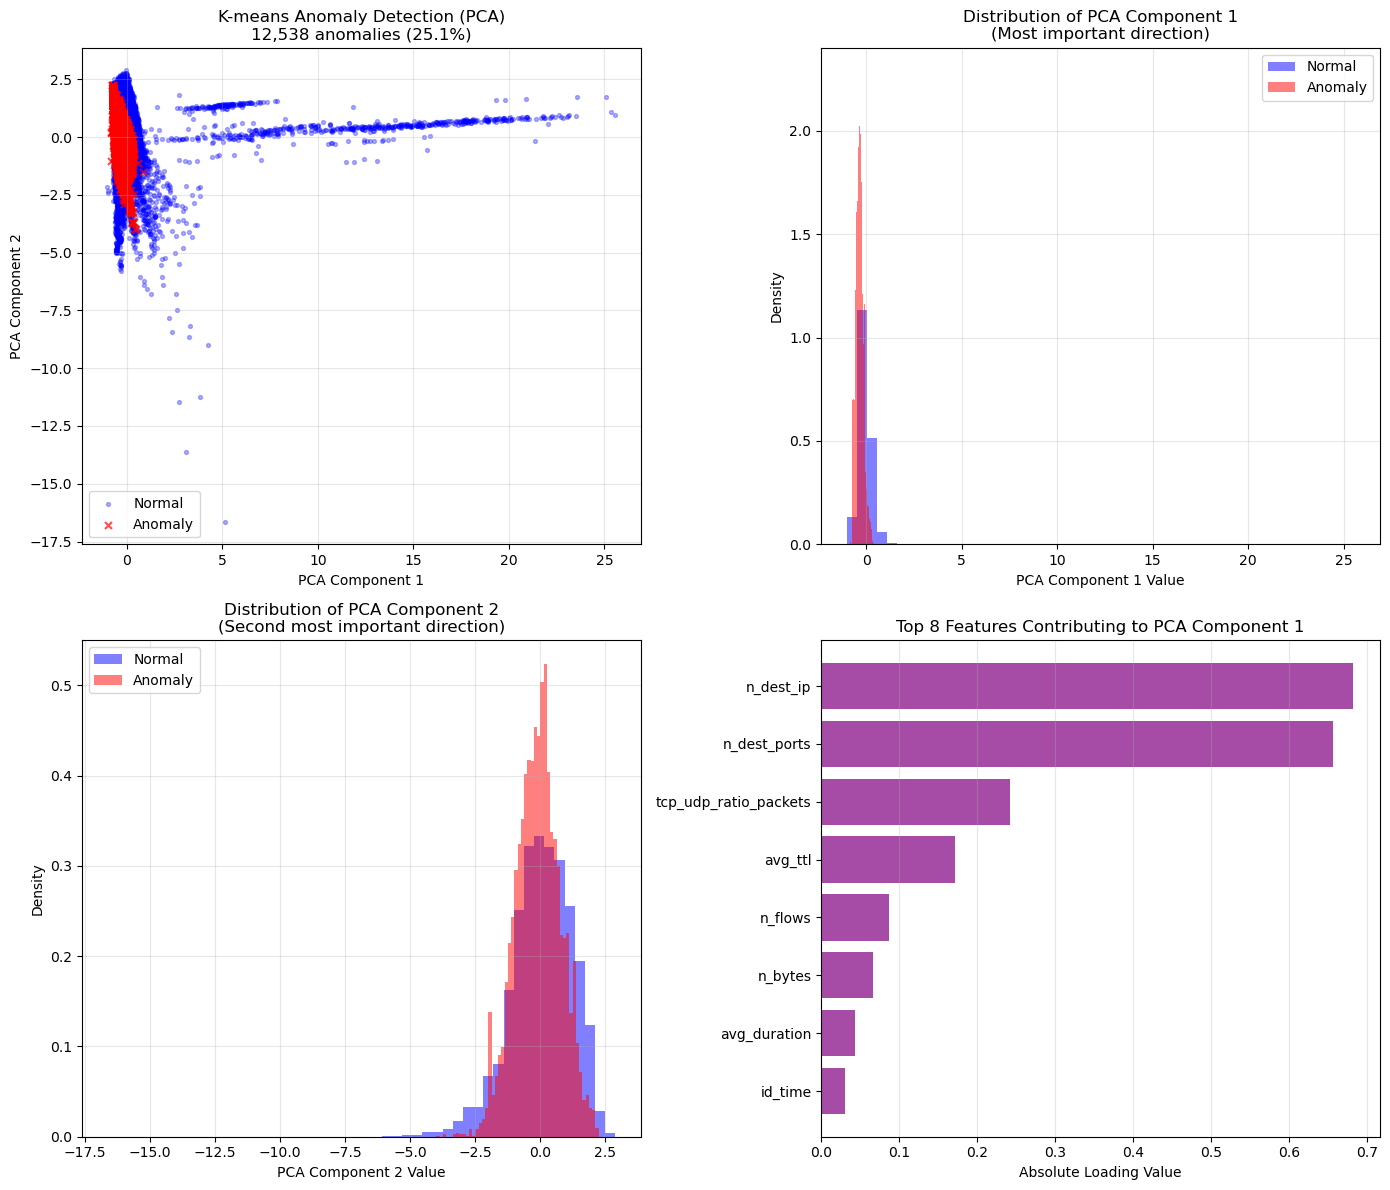

In [47]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(x_train_sample)

print(f"component 1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"component 2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"total: {pca.explained_variance_ratio_.sum():.2%}")

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

#normal points = blue
ax1 = axes[0, 0]
normal_mask = ~anomaly_labels_sample
ax1.scatter(X_pca[normal_mask, 0], X_pca[normal_mask, 1], alpha=0.3, s=8, color='blue', label='Normal')

#anomalies = red
anomaly_mask = anomaly_labels_sample
ax1.scatter(X_pca[anomaly_mask, 0], X_pca[anomaly_mask, 1], alpha=0.7, s=25, color='red', marker='x', label='Anomaly')
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
ax1.set_title(f'K-means Anomaly Detection (PCA)\n{np.sum(anomaly_labels_sample):,} anomalies ({np.sum(anomaly_labels_sample)/len(x_train_sample)*100:.1f}%)')
ax1.legend()
ax1.grid(alpha=0.3)

#pca 1 plot
ax2 = axes[0, 1]
bins = 50
ax2.hist(X_pca[normal_mask, 0], bins=bins, alpha=0.5, color='blue', label='Normal', density=True)
ax2.hist(X_pca[anomaly_mask, 0], bins=bins, alpha=0.5, color='red', label='Anomaly', density=True)
ax2.set_xlabel('PCA Component 1 Value')
ax2.set_ylabel('Density')
ax2.set_title('Distribution of PCA Component 1\n(Most important direction)')
ax2.legend()
ax2.grid(alpha=0.3)

#pca 2 plot
ax3 = axes[1, 0]
ax3.hist(X_pca[normal_mask, 1], bins=bins, alpha=0.5, color='blue', label='Normal', density=True)
ax3.hist(X_pca[anomaly_mask, 1], bins=bins, alpha=0.5, color='red', label='Anomaly', density=True)
ax3.set_xlabel('PCA Component 2 Value')
ax3.set_ylabel('Density')
ax3.set_title('Distribution of PCA Component 2\n(Second most important direction)')
ax3.legend()
ax3.grid(alpha=0.3)

#feature contributions
ax4 = axes[1, 1]
feature_loadings = np.abs(pca.components_[0])
top_n = min(8, len(feature_loadings))
top_indices = np.argsort(feature_loadings)[-top_n:][::-1]

if hasattr(x_scaled_df, 'columns'):
    feature_names = x_scaled_df.columns
else:
    feature_names = [f'Feature {i}' for i in range(x_train_sample.shape[1])]

y_pos = np.arange(top_n)
ax4.barh(y_pos, feature_loadings[top_indices], color='purple', alpha=0.7)
ax4.set_yticks(y_pos)
ax4.set_yticklabels([feature_names[i] for i in top_indices])
ax4.set_xlabel('Absolute Loading Value')
ax4.set_title(f'Top {top_n} Features Contributing to PCA Component 1')
ax4.grid(alpha=0.3, axis='x')
ax4.invert_yaxis()

plt.tight_layout()
plt.show()